In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # To ignore FutureWarning from pandas

In [2]:
import torch

if not torch.cuda.is_available():
    raise Exception('GPU not available.')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')

SEED = 42
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print(f'Device: {torch.cuda.get_device_name(0)} | Seed: {SEED}' )

Device: NVIDIA GeForce GTX 1060 6GB | Seed: 42


In [3]:
import os

DATA_FOLDER = 'data'
SCRIPT_FOLDER = 'scripts'

archive_path = os.path.join(DATA_FOLDER, 'archive.zip')
CLOUD_TEST_PATH = os.path.join(DATA_FOLDER, '38-Cloud_test')
CLOUD_TRAIN_PATH = os.path.join(DATA_FOLDER, '38-Cloud_training')

# flag to check if archive.zip has already been unzipped
is_archive_unzipped = os.path.exists(CLOUD_TEST_PATH) and os.path.exists(CLOUD_TRAIN_PATH)

# raise error if archive.zip has not been found and it has not been unzipped yet
if not os.path.exists(archive_path) and not is_archive_unzipped:
    raise Exception('Error: archive.zip is missing from data folder')

if is_archive_unzipped:
    print('Archive already unzipped.')

Archive already unzipped.


In [4]:
if (is_archive_unzipped == False):
    print('Unzipping archive...')
    !unzip data/archive.zip -d data
    print('Archive Unzipped!')    

In [5]:
if os.path.exists(archive_path) and is_archive_unzipped:
    !rm data/archive.zip
    print('Archive Removed!')

In [6]:
if not os.path.exists('data/38-Cloud_test/test_gt'):
    print('Building test gt...')
    !python3 scripts/build_test_gt.py    

In [7]:
if not os.path.exists('data/testing_patches_38-cloud_nonempty.csv'):
    print('Building test patches...')
    !python3 scripts/build_nonempty.py

In [8]:
train_patches_name = 'training_patches_38-Cloud.csv'
test_patches_name = 'test_patches_38-Cloud.csv'

df_patches_train = pd.read_csv(os.path.join(CLOUD_TRAIN_PATH, train_patches_name))  # patches from 38-Cloud_training
df_patches_train['type'] = 'train'
df_patches_test = pd.read_csv(os.path.join(CLOUD_TEST_PATH, test_patches_name))     # patches from 38-Cloud_test
df_patches_test['type'] = 'test'

df_patches=pd.concat([df_patches_train,df_patches_test]).reset_index(drop=True)     # concatenate the two dataframes

print(f'Patches from train: {len(df_patches_train)} | Patches from test: {len(df_patches_test)}')
#df_patches.head()

tr_non_empty_patches_name = 'training_patches_38-cloud_nonempty.csv'
df_patches_train_non_empty = pd.read_csv(os.path.join(DATA_FOLDER, tr_non_empty_patches_name))
df_patches_train_non_empty['type'] = 'train'
print (f'Number of non-empty training patches: {len(df_patches_train_non_empty)}')

ts_non_empty_patches_name = 'testing_patches_38-cloud_nonempty.csv'
df_patches_test_non_empty = pd.read_csv(os.path.join(DATA_FOLDER, ts_non_empty_patches_name))
df_patches_test_non_empty['type'] = 'test'
print (f'Number of non-empty testing patches: {len(df_patches_test_non_empty)}')


Patches from train: 8400 | Patches from test: 9201
Number of non-empty training patches: 5155
Number of non-empty testing patches: 5009


In [9]:
from torch.utils.data import Dataset, Subset, random_split
from pathlib import Path
from PIL import Image

class Cloud38Dataset(Dataset):
    def __init__(self, patches_df, transform=None):
        super().__init__()        
        self.transform = transform
        self.patches = [self.map_patches(f, t) for f, t in zip(patches_df['name'], patches_df['type'])]           
        self.mean = None
        self.std = None

    def map_patches(self, file_name, type_p):

        folder_path = Path(CLOUD_TEST_PATH) if type_p == 'test' else Path(CLOUD_TRAIN_PATH)

        channels = ['red', 'green', 'blue', 'nir', 'gt']
        paths = {}

        for i in channels:
            path = folder_path / Path(f'{type_p}_{i}') / Path(f'{i}_' + file_name + '.TIF')
            if not os.path.exists(path):
                raise Exception(f'Error: {path} does not exist' )
            paths[i] = path   

        return paths
    
    def __len__(self):
        return len(self.patches)

    def to_array(self, i, invert=False, include_nir=False):
        rgb = np.stack([
            np.array(Image.open(self.patches[i]['red'])),
            np.array(Image.open(self.patches[i]['green'])),
            np.array(Image.open(self.patches[i]['blue'])),
        ], axis=2)

        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.patches[i]['nir'])), axis=2)
            rgb = np.concatenate([rgb, nir], axis=2)

        if invert: # Torch wants the color channel first, so Color x Height x Width
            rgb = rgb.transpose((2, 0, 1))
        
        return rgb / np.iinfo(rgb.dtype).max # images are uint16, so max is 65535
          
    
    def to_mask(self, i, add_dims=False):
        mask = np.array(Image.open(self.patches[i]['gt']))
        mask = np.where(mask == 255, 1, 0)

        if add_dims:
            return np.expand_dims(mask, 0)
        else:
            return mask
        
    def __getitem__(self, i):         
        img = self.to_array(i, invert=False)
        mask = self.to_mask(i)

        #print(f'Image shape: {img.shape} | Mask shape: {mask.shape}')        

        # Apply transformations if defined
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations['image']
            mask = augmentations['mask']
            # Return type is Tensor

        else:        
            img = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask        

In [10]:
# Setup custom cmap for mask
custom_cmap = plt.colormaps['viridis']  # We change the default colormap to make sure that 0 is purple and 1 is yellow
custom_cmap.set_under('purple')         # Wven when the mask has only 0s or 1s
custom_cmap.set_over('yellow')

print(custom_cmap)

In [11]:
# Load of training dataset
data_train = Cloud38Dataset(df_patches_train_non_empty)     # We use non empty patches for more efficient training
print(f'Loaded Training data   | Length: {len(data_train)}')

data_test_val = Cloud38Dataset(df_patches_test_non_empty, transform=None)
dtv_len2 = len(data_test_val) // 2
data_test, data_val = random_split(data_test_val, [dtv_len2 + 1, dtv_len2])
print(f'Loaded Testing data    | Length: {len(data_test)}')
print(f'Loaded Validation data | Length: {len(data_val)}')

Loaded Training data   | Length: 5155
Loaded Testing data    | Length: 2505
Loaded Validation data | Length: 2504


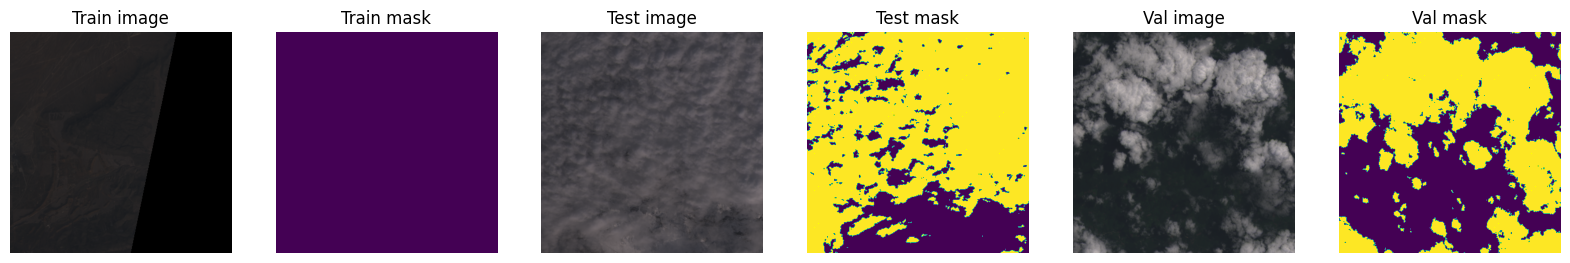

In [12]:
train_index = np.random.randint(0, len(data_train))
test_index = np.random.randint(0, len(data_test))
val_index = np.random.randint(0, len(data_val))

idxs = {'train': train_index, 'test': test_index, 'val': val_index}

fig, ax = plt.subplots(1, 6, figsize=(20, 15))

x = 0
for i, j in enumerate(idxs):
    ax[i*2].imshow(data_train.to_array(idxs[j]))
    ax[i*2].set_title(f'{j.capitalize()} image')
    ax[i*2].set_axis_off()
    ax[i*2+1].imshow(data_train.to_mask(idxs[j]), cmap=custom_cmap, vmin=0, vmax=1)
    ax[i*2+1].set_title(f'{j.capitalize()} mask')
    ax[i*2+1].set_axis_off()       


In [13]:
from torch.utils.data import DataLoader
IMAGE_SIZE = 384

if False: # Temporary flag to disable mean and std computation
    loader_train = DataLoader(data_train, batch_size=32)

    pixel_sum = torch.tensor([0.0, 0.0, 0.0])
    pixel_sum_sq = torch.tensor([0.0, 0.0, 0.0])

    for x, y in loader_train:
        pixel_sum += x.sum(axis=(0, 2, 3))
        pixel_sum_sq += (x ** 2).sum(axis=(0, 2, 3))

    count = len(data_train) * IMAGE_SIZE * IMAGE_SIZE
    mean = pixel_sum / count
    var = (pixel_sum_sq / count) - (mean ** 2)
    std = torch.sqrt(var)

else:
    mean = torch.tensor([0.2400, 0.2366, 0.2508])
    std = torch.tensor([0.1451, 0.1393, 0.1443])

print(f'Computed mean and std for the dataset:\n Mean: {mean} | Std: {std}')

Computed mean and std for the dataset:
 Mean: tensor([0.2400, 0.2366, 0.2508]) | Std: tensor([0.1451, 0.1393, 0.1443])


In [14]:
# TODO: ALWAYS ENABLE LOAD_MODEL FOR OLD MODELS OR THEY WILL BE OVERWRITTEN

# Hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
NUM_EPOCHS = 15

# Model
MODEL_NAME = 'unet_256_firstborn'
LOAD_MODEL= False

# Data
IMAGE_RESIZE = 256
SUBSET_TRAIN = 1200
SUBSET_VAL = 500
NORMALIZE = True

# Other
PIN_MEMORY = True
MODELS_FOLDER = 'models'
OUTPUT_FOLDER = 'out'
DEVICE = device

In [15]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define some augmentations
norm_aug = A.Compose([    
    A.Resize(height=IMAGE_RESIZE, width=IMAGE_RESIZE),
    A.Rotate(limit=180, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
    mean=mean.tolist(),   # mean=mean.tolist() | mean=[0.0, 0.0, 0.0]
    std=std.tolist(),     # std=std.tolist()   | std=[1.0, 1.0, 1.0]
    max_pixel_value=1,    
    ),
    ToTensorV2(),       
])

norm_res = A.Compose([    
    A.Resize(height=IMAGE_RESIZE, width=IMAGE_RESIZE),
    A.Normalize(
    mean=mean.tolist(),  
    std=std.tolist(),   
    max_pixel_value=1,    
    ),
    ToTensorV2(),       
])

norm_no_res = A.Compose([
    A.Normalize(
    mean=mean.tolist(),  
    std=std.tolist(),   
    max_pixel_value=1,    
    ),
    ToTensorV2(),       
])

In [16]:
# Apply augmentations
train_transform = norm_aug
val_transforms = norm_res

In [17]:
if NORMALIZE: # True for training with augmentations
    norm_train = Cloud38Dataset(df_patches_train_non_empty, transform=train_transform)
    norm_val = Cloud38Dataset(df_patches_test_non_empty, transform=val_transforms)
else:
    norm_train = Cloud38Dataset(df_patches_train_non_empty, transform=None)
    norm_val = Cloud38Dataset(df_patches_test_non_empty, transform=None)

if SUBSET_TRAIN is not None and SUBSET_VAL is not None:
    sub_train = Subset(norm_train, np.random.randint(0, len(data_train), SUBSET_TRAIN),)
    sub_val = Subset(norm_val, np.random.randint(0, len(data_val), SUBSET_VAL))
else:
    sub_train = norm_train
    sub_val = norm_val

print(f'Length of sub_train: {len(sub_train)} | Length of sub_val: {len(sub_val)}')


Length of sub_train: 1200 | Length of sub_val: 500


Normalized image sits between -1.0514272451400757 and 3.4520418643951416


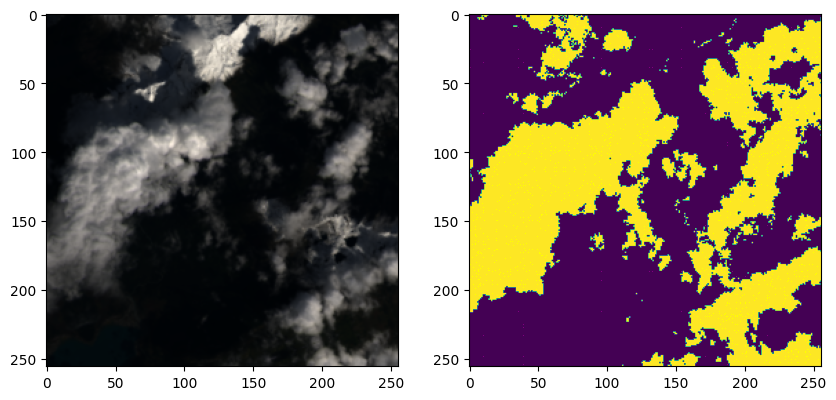

In [21]:
# Let's check the output of normalization
dl_normalized = DataLoader(sub_train, shuffle=True)
for x, y in dl_normalized:
    z = x[0].permute(1, 2, 0)
    z = (z - z.min()) / (z.max() - z.min())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(z)    
    ax[1].imshow(y[0], cmap=custom_cmap, vmin=0, vmax=1)   
    print(f'Normalized image sits between {x.min()} and {x.max()}')    
    break

In [22]:
import torch.nn as nn
import torch.optim as optim
from model import UNET
from tqdm import tqdm
from utils import (
    load_checkpoint, 
    save_checkpoint,  
    save_predictions_as_imgs,
    evaluate_model,
    update_metrics,
    get_val_loss,
    update_losses,
)

In [23]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader) 

    total_loss = 0
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            #print(f'Predictions shape: {predictions.shape} | Targets shape: {targets.shape}')
            loss = loss_fn(predictions, targets)           

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        # update tqdm loop
        loop.set_postfix(loss=loss.item())

    return total_loss / len(loader)

In [22]:
def save_log(model_name, lr, batch_size, epoches, resize, subset_size, normalize):
    log = {
        'model_name': model_name,
        'lr': lr,
        'batch_size': batch_size,
        'epoches': epoches,
        'resize': resize,
        'subset_size': subset_size,
        'normalize': normalize,
    }
    with open(os.path.join(MODELS_FOLDER, f'{model_name}_parameters.txt'), 'w') as f:
        f.write(str(log))

In [24]:
def tr_model(out = 'losses'):    
    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss() # Binary Cross Entropy with Logits
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    if out == 'losses':
        df_losses = pd.DataFrame(columns=['model', 'epoch', 'train_loss', 'val_loss'])
    else:
        df_metrics = pd.DataFrame(columns=['model', 'epoch', 'train_loss', 'val_loss', 'accuracy', 'precision', 'recall', 'f1'])    
    
    train_loader = DataLoader(
        dataset=sub_train,
        batch_size=BATCH_SIZE,
        shuffle=True,        
        pin_memory=PIN_MEMORY,
    )

    val_loader = DataLoader(
        dataset=sub_val,
        batch_size=1,
        shuffle=False,        
        pin_memory=PIN_MEMORY,
    )    

    model_path = os.path.join(MODELS_FOLDER, f'{MODEL_NAME}.pth.tar')
    if LOAD_MODEL:
        load_checkpoint(torch.load(model_path), model)               

    scaler = torch.cuda.amp.GradScaler()
    PATIENCE = 7
    max_tr_loss = np.inf
    curr_patience = PATIENCE
    for epoch in range(NUM_EPOCHS):
        if curr_patience == 0:
            print(f'Early stopping at epoch {epoch}')
            break

        train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

        if np.isnan(train_loss):
            print(f'NaN loss at epoch {epoch}')
            break

        if train_loss < max_tr_loss:
            max_tr_loss = train_loss
            curr_patience = PATIENCE
        else:
            curr_patience -= 1     

        checkpoint = {'state_dict': model.state_dict()}
        save_checkpoint(checkpoint, filename=model_path)

        if out == 'losses':
            df_losses = update_losses(df_losses, model, loss_fn, MODEL_NAME, epoch, train_loss)
        else:
            df_metrics = update_metrics(df_metrics, val_loader, model, loss_fn, MODEL_NAME, epoch, train_loss)        
        
        save_predictions_as_imgs(
            val_loader, model, folder='imgs/', device=DEVICE
        )

        print(f"Epoch {epoch} completed! with loss: {train_loss:.2f}")

    save_log(MODEL_NAME, LEARNING_RATE, BATCH_SIZE, NUM_EPOCHS, IMAGE_RESIZE, SUBSET_TRAIN, NORMALIZE)

    if out == 'losses':
        df_losses.to_csv(os.path.join(MODELS_FOLDER, f'{MODEL_NAME}_metrics.csv'), index=False)
    else:
        df_metrics.to_csv(os.path.join(MODELS_FOLDER, f'{MODEL_NAME}_metrics.csv'), index=False)

In [25]:
def tr_baseline_lr(rates, model_names, epochs=NUM_EPOCHS):
    if len(rates) != len(model_names):
        raise Exception('Error: rates and model_names must have the same length')

    PATIENCE = 7
    for i in range(len(rates)):
        lr = rates[i]
        model_name = model_names[i]

        model = UNET(in_channels=3, out_channels=1).to(DEVICE)
        p_weight = torch.tensor([2.0]).to(DEVICE)
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=p_weight) # Binary Cross Entropy with Logits
        optimizer = optim.Adam(model.parameters(), lr=lr)

        df_losses = pd.DataFrame(columns=['model', 'epoch', 'train_loss', 'val_loss'])
        
        train_loader = DataLoader(
            dataset=sub_train,
            batch_size=BATCH_SIZE,
            shuffle=True,        
            pin_memory=PIN_MEMORY,
        )

        val_loader = DataLoader(
            dataset=sub_val,
            batch_size=1,
            shuffle=False,        
            pin_memory=PIN_MEMORY,
        )

        model_path = os.path.join(MODELS_FOLDER, f'{model_name}.pth.tar')

        if LOAD_MODEL:
            load_checkpoint(torch.load(model_path), model)
        
        scaler = torch.cuda.amp.GradScaler()
        max_tr_loss = np.inf
        curr_patience = PATIENCE
        for epoch in range(epochs):              
            if curr_patience == 0:
                print(f'Early stopping for model {model_name} at epoch {epoch}')
                break
                      
            train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
            if np.isnan(train_loss):
                print(f'NaN loss for model {model_name} at epoch {epoch}')
                break

            if train_loss < max_tr_loss:
                max_tr_loss = train_loss
                curr_patience = PATIENCE
            else:
                curr_patience -= 1

            checkpoint = {'state_dict': model.state_dict()}
            save_checkpoint(checkpoint, filename=model_path)

            df_losses = update_losses(df_losses, val_loader, model, loss_fn, model_name, epoch, train_loss)
            print(f"Epoch {epoch} completed for model {model_name}! with loss: {train_loss:.2f}")

        save_log(model_name, lr, BATCH_SIZE, epochs, IMAGE_RESIZE, SUBSET_TRAIN, NORMALIZE)
        df_losses.to_csv(os.path.join(MODELS_FOLDER, f'{model_name}_losses.csv'), index=False)

    print("Baseline training completed!") 

In [24]:
# Placeholder for testing to do
if __name__ == "__main__":
    baseline_training = {
        'rates': [1e-1, 1e-2, 1e-3, 1e-4],
        'model_names': ['unet_128_1e-1', 'unet_128_1e-2', 'unet_128_1e-3', 'unet_128_1e-4']
    } 

    baseline_training_c = {
        'rates' : [1e-4, 1e-3],
        'model_names': ['unet_128_1e-4', 'unet_128_1e-3']
    }

    if False:
        tr_baseline_lr(baseline_training_c['rates'], baseline_training_c['model_names'])  

    if True:
        tr_model(out='metrics')   

100%|██████████| 38/38 [15:14<00:00, 24.08s/it, loss=0.403]


Saving checkpoint
Accuracy: 0.83
Precision: 0.88
Recall: 0.77
F1 score: 0.82
Loss: 0.58
Epoch 0 completed! with loss: 0.41


100%|██████████| 38/38 [15:13<00:00, 24.04s/it, loss=0.454]


Saving checkpoint
Accuracy: 0.76
Precision: 0.97
Recall: 0.54
F1 score: 0.69
Loss: 0.60
Epoch 1 completed! with loss: 0.35


100%|██████████| 38/38 [14:58<00:00, 23.64s/it, loss=0.419]


Saving checkpoint
Accuracy: 0.81
Precision: 0.96
Recall: 0.65
F1 score: 0.77
Loss: 0.58
Epoch 2 completed! with loss: 0.32


100%|██████████| 38/38 [11:30<00:00, 18.16s/it, loss=0.378]


Saving checkpoint
Accuracy: 0.75
Precision: 0.99
Recall: 0.51
F1 score: 0.68
Loss: 0.60
Epoch 3 completed! with loss: 0.30


100%|██████████| 38/38 [15:29<00:00, 24.46s/it, loss=0.422]


Saving checkpoint
Accuracy: 0.87
Precision: 0.95
Recall: 0.78
F1 score: 0.86
Loss: 0.56
Epoch 4 completed! with loss: 0.31


100%|██████████| 38/38 [13:36<00:00, 21.50s/it, loss=0.384]


Saving checkpoint
Accuracy: 0.86
Precision: 0.81
Recall: 0.94
F1 score: 0.87
Loss: 0.58
Epoch 5 completed! with loss: 0.31


100%|██████████| 38/38 [13:27<00:00, 21.26s/it, loss=0.299]


Saving checkpoint
Accuracy: 0.90
Precision: 0.93
Recall: 0.86
F1 score: 0.89
Loss: 0.55
Epoch 6 completed! with loss: 0.31


100%|██████████| 38/38 [16:31<00:00, 26.09s/it, loss=0.311]


Saving checkpoint
Accuracy: 0.86
Precision: 0.97
Recall: 0.75
F1 score: 0.85
Loss: 0.55
Epoch 7 completed! with loss: 0.27


100%|██████████| 38/38 [15:29<00:00, 24.45s/it, loss=0.312]


Saving checkpoint
Accuracy: 0.83
Precision: 0.98
Recall: 0.68
F1 score: 0.80
Loss: 0.57
Epoch 8 completed! with loss: 0.26


100%|██████████| 38/38 [14:56<00:00, 23.59s/it, loss=0.37] 


Saving checkpoint
Accuracy: 0.88
Precision: 0.94
Recall: 0.82
F1 score: 0.87
Loss: 0.55
Epoch 9 completed! with loss: 0.27


100%|██████████| 38/38 [13:43<00:00, 21.67s/it, loss=0.381]


Saving checkpoint
Accuracy: 0.89
Precision: 0.94
Recall: 0.85
F1 score: 0.89
Loss: 0.55
Epoch 10 completed! with loss: 0.26


100%|██████████| 38/38 [13:35<00:00, 21.47s/it, loss=0.247]


Saving checkpoint
Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 score: 0.90
Loss: 0.55
Epoch 11 completed! with loss: 0.26


100%|██████████| 38/38 [13:25<00:00, 21.20s/it, loss=0.336]


Saving checkpoint
Accuracy: 0.85
Precision: 0.98
Recall: 0.72
F1 score: 0.83
Loss: 0.56
Epoch 12 completed! with loss: 0.24


100%|██████████| 38/38 [17:58<00:00, 28.38s/it, loss=0.247]


Saving checkpoint
Accuracy: 0.86
Precision: 0.98
Recall: 0.74
F1 score: 0.84
Loss: 0.56
Epoch 13 completed! with loss: 0.23


100%|██████████| 38/38 [13:27<00:00, 21.25s/it, loss=0.247]


Saving checkpoint
Accuracy: 0.87
Precision: 0.98
Recall: 0.76
F1 score: 0.85
Loss: 0.55
Epoch 14 completed! with loss: 0.23


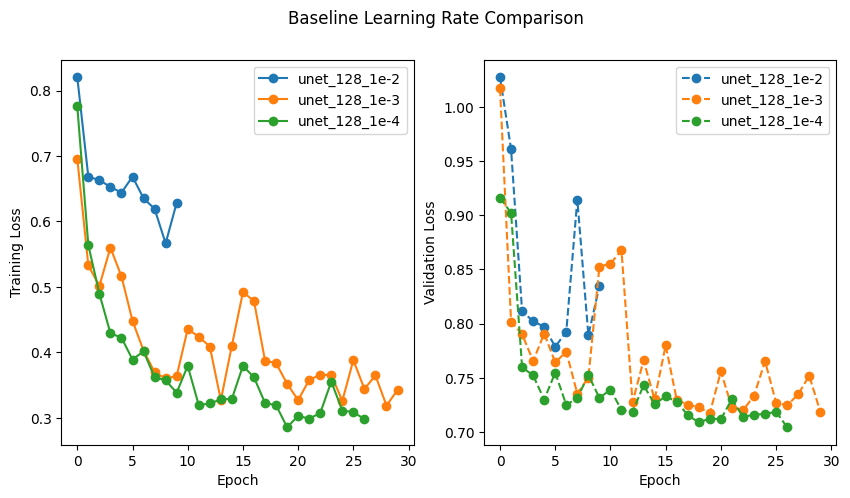

In [28]:
baseline_lrs = ['1e-2', '1e-3', '1e-4',]

df_baseline_lr = pd.DataFrame(columns=['model', 'epoch', 'train_loss', 'val_loss'])

for lr in baseline_lrs:
    df_baseline_lr = pd.concat([df_baseline_lr, pd.read_csv(os.path.join(MODELS_FOLDER, f'unet_128_{lr}_losses.csv'), dtype={'epoch': int})]).reset_index(drop=True)

df_baseline_lr = df_baseline_lr.pivot(index='epoch', columns='model', values=['val_loss', 'train_loss'])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for model in df_baseline_lr.columns.levels[1]:
    ax[0].plot(df_baseline_lr.index, df_baseline_lr[('train_loss', model)], label=model, marker='o')
    ax[1].plot(df_baseline_lr.index, df_baseline_lr[('val_loss', model)], label=model, marker='o', linestyle='--')

for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()
    if i == 0:
        ax[i].set_ylabel('Training Loss')
    else:
        ax[i].set_ylabel('Validation Loss')

fig.suptitle('Baseline Learning Rate Comparison')
fig.savefig(os.path.join(OUTPUT_FOLDER, 'baseline_128_lr_comparison.png'), dpi=300)

In [30]:
# i wanna display the metrics for the three models
df_baseline_metrics = pd.DataFrame(columns=['model', 'loss', 'accuracy', 'precision', 'recall', 'f1'])

for lr in baseline_lrs:
    model_name = f'unet_128_{lr}'    
    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    load_checkpoint(torch.load(os.path.join(MODELS_FOLDER, f'{model_name}.pth.tar')), model)

    val_loader = DataLoader(dataset = sub_val, batch_size=1, shuffle=False, pin_memory=PIN_MEMORY)
    metrics = evaluate_model(val_loader, model, nn.BCEWithLogitsLoss() , DEVICE)
    row = {'model': model_name, 'loss': metrics[4], 'accuracy': metrics[0], 'precision': metrics[1], 'recall': metrics[2], 'f1': metrics[3]}
    df_baseline_metrics = pd.concat([df_baseline_metrics, pd.DataFrame(row, index=[0])]).reset_index(drop=True)

df_baseline_metrics.head()

Loading checkpoint
Accuracy: 0.76
Precision: 0.77
Recall: 0.78
F1 score: 0.78
Loss: 0.61
Loading checkpoint
Accuracy: 0.79
Precision: 0.73
Recall: 0.94
F1 score: 0.83
Loss: 0.62
Loading checkpoint
Accuracy: 0.85
Precision: 0.80
Recall: 0.96
F1 score: 0.87
Loss: 0.58


,model,loss,accuracy,precision,recall,f1
0,unet_128_1e-2,0.611074,0.763765,0.774652,0.779238,0.776938
1,unet_128_1e-3,0.616044,0.789313,0.733700,0.943334,0.825414
2,unet_128_1e-4,0.580129,0.850444,0.798296,0.959055,0.871322


Il modello con lr=0.01 diverge dopo poche epoch mentre a parità di epoches il modello con lr=0.0001 ha degli score migliori.

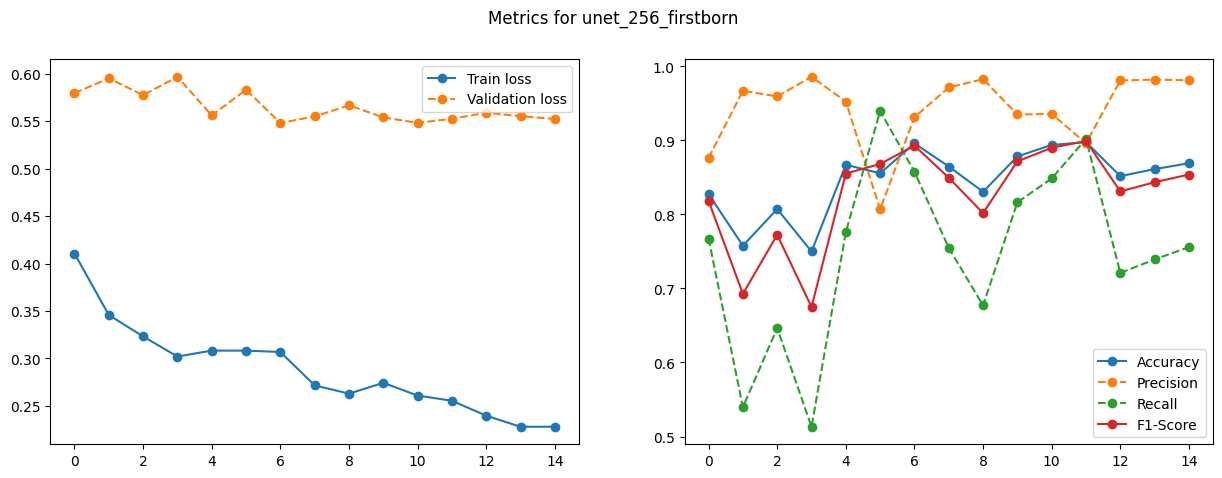

In [32]:
df_metrics = pd.read_csv(os.path.join(MODELS_FOLDER, f'{MODEL_NAME}_metrics.csv'), dtype={'epoch': int})

ep = df_metrics['epoch']
tr_loss = df_metrics['train_loss']
val_loss = df_metrics['val_loss']
acc = df_metrics['accuracy']
prec = df_metrics['precision']
rec = df_metrics['recall']
f1 = df_metrics['f1']

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(ep, tr_loss, label='Train loss', marker='o')
ax[0].plot(ep, val_loss, label='Validation loss', marker='o', linestyle='--')
ax[0].legend()

ax[1].plot(ep, acc, label='Accuracy', marker='o')
ax[1].plot(ep, prec, label='Precision', marker='o' , linestyle='--')
ax[1].plot(ep, rec, label='Recall', marker='o', linestyle='--' )
ax[1].plot(ep, f1, label='F1-Score',  marker='o')
ax[1].legend()
fig.suptitle(f'Metrics for {MODEL_NAME}')
fig.savefig(os.path.join(OUTPUT_FOLDER, f'{MODEL_NAME}_metrics.png'))

In [ ]:
# I would use an early stopping at epoch 12

Random results range: [ 5 16  2 24 14]


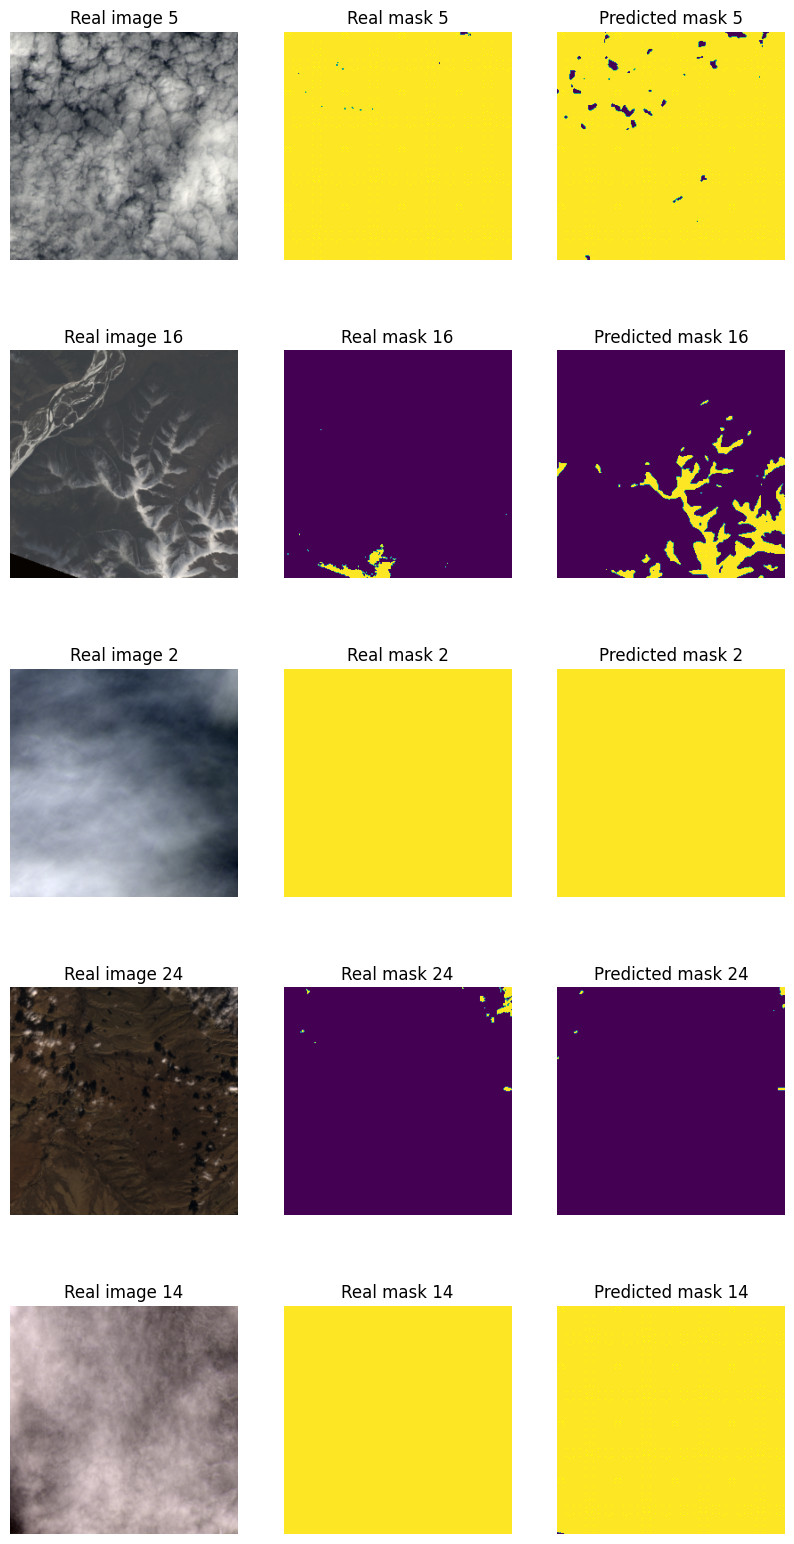

In [35]:
NUM_ELEM_SHOW = 5
RESULTS_RANGE = np.random.choice(31, NUM_ELEM_SHOW, replace=False)
print(f'Random results range: {RESULTS_RANGE}')

fig, axs = plt.subplots(NUM_ELEM_SHOW, 3, figsize=(10, 20))

for i, index in enumerate(RESULTS_RANGE):
    pred_img_mask_name = f'imgs/pred_{index}.png'
    pred_img_mask = Image.open(pred_img_mask_name)
    pred_img_mask = np.where(np.array(pred_img_mask) == 255, 1, 0)
    pred_img_mask = (pred_img_mask[:, :, 0])

    real_img, real_img_mask = sub_val[index]
    real_img = (real_img - real_img.min()) / (real_img.max() - real_img.min())
    real_img_mask = real_img_mask.numpy().astype(np.int64)

    axs[i, 0].imshow(real_img.permute(1, 2, 0))
    axs[i, 0].set_title(f'Real image {index}')
    axs[i, 0].set_axis_off()

    axs[i, 1].imshow(real_img_mask, cmap=custom_cmap, vmin=0, vmax=1)
    axs[i, 1].set_title(f'Real mask {index}')
    axs[i, 1].set_axis_off()

    axs[i, 2].imshow(pred_img_mask, cmap=custom_cmap, vmin=0, vmax=1)
    axs[i, 2].set_title(f'Predicted mask {index}')
    axs[i, 2].set_axis_off()

In [35]:
TEST_MODEL_NAME = 'unet_256_firstborn'
TEST_MODEL_PATH = os.path.join(MODELS_FOLDER, f'{TEST_MODEL_NAME}.pth.tar')

norm_test = Cloud38Dataset(df_patches_test_non_empty, transform=norm_no_res)
print(f'Length of norm_test: {len(norm_test)}')

sub_test = Subset(norm_test, np.random.randint(0, len(norm_test), 500))

test_loader = DataLoader(
    dataset=sub_test,
    batch_size=1,
    shuffle=False,        
    pin_memory=PIN_MEMORY,
)

print(f'Length of test_loader: {len(test_loader)}')

Length of norm_test: 5009
Length of test_loader: 500


In [36]:
test_model = UNET(in_channels=3, out_channels=1).to(DEVICE)
load_checkpoint(torch.load(TEST_MODEL_PATH), test_model)
print('Model loaded successfully.')
evaluate_model(test_loader, test_model, loss_fn=nn.BCEWithLogitsLoss(), device=DEVICE)
save_predictions_as_imgs(test_loader, test_model, folder=f'test/{TEST_MODEL_NAME}/', device=DEVICE)

Loading checkpoint
Model loaded successfully.
Accuracy: 0.88
Precision: 0.97
Recall: 0.79
F1 score: 0.87
Loss: 0.55


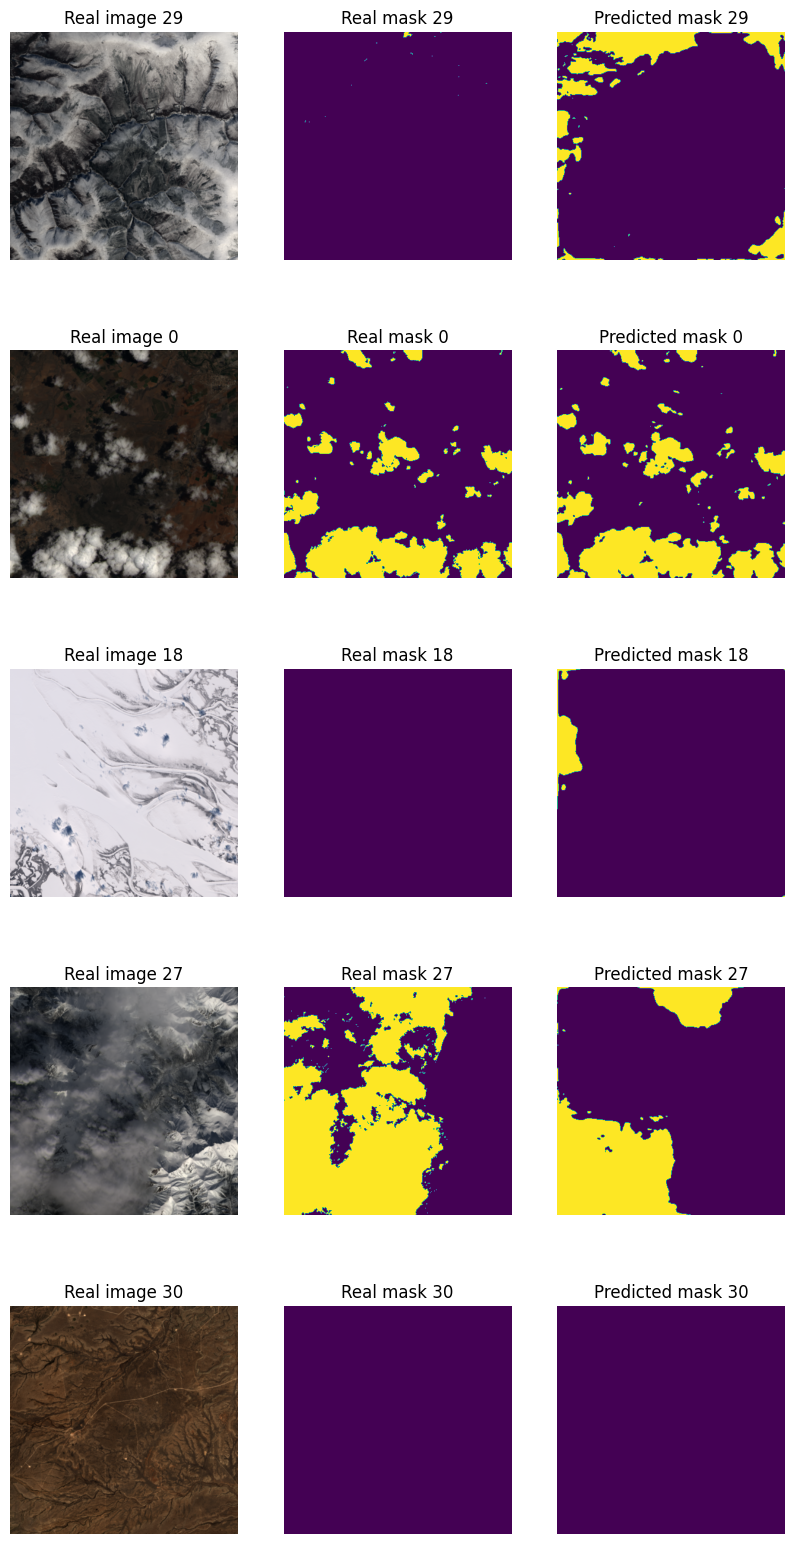

In [67]:
NUM_TEST_SHOW = 5
RESULTS_RANGE = np.random.choice(31, NUM_TEST_SHOW, replace=False)
fig, axs = plt.subplots(NUM_TEST_SHOW, 3, figsize=(10, 20))

for i, index in enumerate(RESULTS_RANGE):
    pred_img_mask_name = f'test/{TEST_MODEL_NAME}/pred_{index}.png'
    pred_img_mask = Image.open(pred_img_mask_name)
    pred_img_mask = np.where(np.array(pred_img_mask) == 255, 1, 0)
    pred_img_mask = (pred_img_mask[:, :, 0])

    real_img, real_img_mask = sub_test[index]
    real_img = (real_img - real_img.min()) / (real_img.max() - real_img.min())
    real_img_mask = real_img_mask.numpy().astype(np.int64)

    axs[i, 0].imshow(real_img.permute(1, 2, 0))
    axs[i, 0].set_title(f'Real image {index}')
    axs[i, 0].set_axis_off()

    axs[i, 1].imshow(real_img_mask, cmap=custom_cmap, vmin=0, vmax=1)
    axs[i, 1].set_title(f'Real mask {index}')
    axs[i, 1].set_axis_off()

    axs[i, 2].imshow(pred_img_mask, cmap=custom_cmap, vmin=0, vmax=1)
    axs[i, 2].set_title(f'Predicted mask {index}')
    axs[i, 2].set_axis_off()

In [49]:
for name, param in test_model.named_parameters():
    print(f'Name: {name} | Param: {param.data.flatten()}')

print(f'Number of parameters: {sum(p.numel() for p in test_model.parameters())}')

Name: ups.0.weight | Param: tensor([ 0.0201,  0.0435,  0.0059,  ..., -0.0225, -0.0446, -0.0411],
       device='cuda:0')
Name: ups.0.bias | Param: tensor([ 2.3299e-02,  1.1818e-01,  1.1679e-02, -3.9232e-03,  1.7438e-01,
         1.4543e-02, -1.0377e-01,  3.6808e-02, -5.3368e-02, -2.6739e-02,
        -4.6281e-02, -3.5586e-02,  9.5479e-02,  2.9780e-02,  9.7605e-03,
         6.3725e-02,  1.3429e-02,  2.4799e-02, -4.1810e-02,  7.8700e-02,
         2.8881e-02,  5.0907e-02,  8.8023e-02, -4.6860e-03, -3.5463e-02,
         9.9551e-02,  7.3163e-03, -9.6040e-04, -3.8760e-02,  3.4287e-02,
         2.4131e-02,  9.4875e-02, -3.8497e-02, -1.0701e-02,  4.5828e-02,
         7.0988e-02,  4.2107e-02, -9.8401e-02,  5.3556e-02,  8.1782e-02,
        -3.0183e-02, -4.3938e-02,  5.5296e-03, -2.1215e-02, -4.8243e-02,
        -6.5872e-02, -5.9240e-02, -5.5836e-02,  1.6866e-03,  1.1306e-01,
         6.8558e-02,  5.2295e-02,  2.7394e-02, -4.2309e-02, -1.0085e-01,
        -2.3034e-02,  9.3435e-02, -1.4815e-02, -1.

#### Considerazioni finali

Il modello è stato addestrato su un subset del dataset di train (1200 immagini) e testato su un subset del dataset di test (500 immagini). E' stato addestrato per 15 epoches con un learning rate di 1e-4 e un batch size di 32. Inoltre le imamgini che sono state utilizzate sono state ridimensionate per l'addestramento a 256x256 per velocizzare il processo di addestramento.

Dalle predizioni effettuate sul test set si nota come il modello sia in grado di riconoscere correttamente quanto l'immagine sia costituita esclusivamente da nuvole o ve ne sia un'assenza totale. Per quanto riguarda le immagini dove sono presenti nuvole più piccole (delle quali se ne può distinguere chiaramente il contorno) la segmentazione avviene in maniera piuttosto accurata nonostante i bordi delle nuvole vadano a perdere nitidezza.
Con un training effettuato su immagini non ridimensionate e con un numero maggiore di epoches si potrebbe ottenere un modello che distingua in maniera più accurata il contorno delle nuvole.

Un punto debole del modello è data dalla sua scarsa capacità di distinguere le nuvole dalle vette innevate che per somiglianza in forma e colore vengono spesso classificate in maniera errata come nuvole.
Nonostante questo il modello è in grado di distingure in maniera piuttosto accurata un paesaggio innevato da un cielo nuvoloso.
